In [1]:
import sys
sys.executable

'd:\\software\\python37\\python.exe'

In [1]:
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb 
from sklearn import tree
from sklearn.svm import SVC
import keras
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.metrics import mean_squared_error as MSE
from sklearn.feature_selection import RFE
from keras.utils import np_utils, plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from keras import optimizers
import keras_metrics as km
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time 
import datetime

In [2]:
import shap
shap.initjs()

## load data

In [2]:
cf = pd.read_excel(r"data\\L1\\cf12.xls")
eo = pd.read_excel(r"data\\L1\\eo14.xls")
fwc = pd.read_excel(r"data\\L1\\fwc10.xls")
fwe = pd.read_excel(r"data\\L1\\fwe10.xls")
nc = pd.read_excel(r"data\\L1\\nc1.xls")
rl = pd.read_excel(r"data\\L1\\rl10.xls")
ro = pd.read_excel(r"data\\L1\\ro10.xls")
normal = pd.read_excel(r"data\\L1\\normal.xls")
data=pd.concat([cf,eo,fwc,fwe,nc,rl,ro,normal],ignore_index=True)

In [3]:
x = data.iloc[:,data.columns != "Y"]
y = data.iloc[:,data.columns == "Y"] 
xtrain, xtest, ytrain, ytest = train_test_split(xr,y,test_size=0.3,random_state=10,stratify=y)

## Random Forest

In [9]:
rfc = RandomForestClassifier(random_state=10,oob_score=True)
rfc.fit(xtrain, ytrain)
time0 = time.time()
rfc_pred = rfc.predict(xtest)
rfc_f1 = f1_score(ytest, rfc_pred,average='weighted')
print("time: %.4f"% (time.time()-time0))
print("f1_score: %.4f"%  (rfc_f1))
print(classification_report(ytest, rfc_pred,digits=4))

time: 0.1651
f1_score: 0.9996
              precision    recall  f1-score   support

          CF     0.9994    1.0000    0.9997      1557
          EO     0.9981    1.0000    0.9990      1557
         FWC     1.0000    1.0000    1.0000      1557
         FWE     1.0000    0.9994    0.9997      1557
          NC     1.0000    1.0000    1.0000      1557
      Normal     0.9994    1.0000    0.9997      1557
          RL     1.0000    0.9974    0.9987      1557
          RO     1.0000    1.0000    1.0000      1557

    accuracy                         0.9996     12456
   macro avg     0.9996    0.9996    0.9996     12456
weighted avg     0.9996    0.9996    0.9996     12456



### SHAP analysis of RF

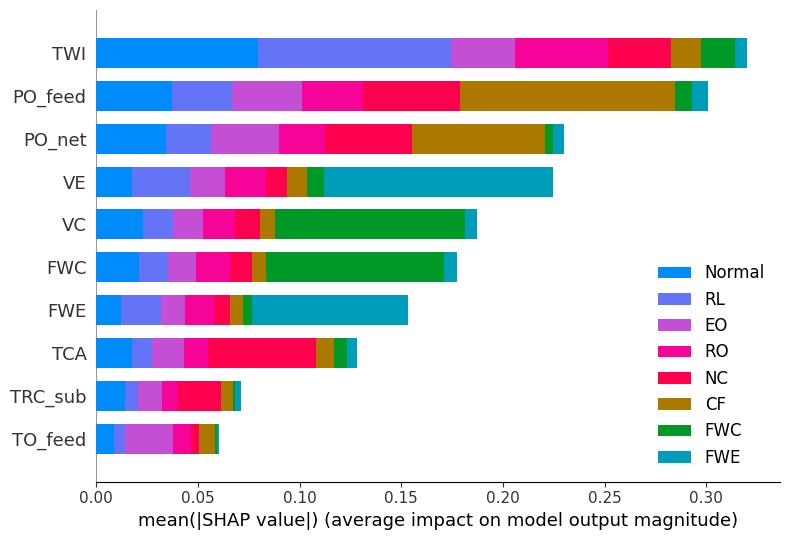

In [8]:
#使用tree explainer
explainer = shap.TreeExplainer(rfc)
#计算shap值
shap_values = explainer.shap_values(xtrain)
#基线值 就是训练集的目标变量的拟合值的均值
expected_value = explainer.expected_value
class_names = ['CF','EO','FWC','FWE','NC','RL','RO','Normal']
shap.summary_plot(shap_values
                  ,xtrain
                  ,class_names= class_names
                  ,max_display = 10
                  #,feature_names=feature_names
                  #,plot_type="bar"
                  )

## LightGBM

In [10]:
lgbm=lgb.LGBMClassifier(boosting_type='gbdt'
                          ,objective='multiclass'
                          ,metrics='multi_error'
                          ,num_class=8 
#                           ,learning_rate=0.05499119315561508
#                           ,n_estimators=396
#                           ,max_depth=4
#                           ,num_leaves=92
#                           ,max_bin=16
#                        ,min_data_in_leaf=21
#                        ,bagging_fraction=0.8,bagging_freq=10,feature_fraction=0.8
#                        ,lambda_l1=0.02,lambda_l2=0.02
#                        ,min_split_gain=0.1
                       )
lgbm.fit(xtrain,ytrain)
time1 = time.time()
lgb_preds=lgbm.predict(xtest)
print('time:',time.time()-time1)
pred_l = lgbm.predict_proba(xtest) 

f1 = f1_score(ytest, lgb_preds,average='weighted')
print("f1_score: %.4f"%  (f1))
print(classification_report(ytest, lgb_preds,digits=4))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12885
[LightGBM] [Info] Number of data points in the train set: 29064, number of used features: 63
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

### SHAP analysis of LightGBM

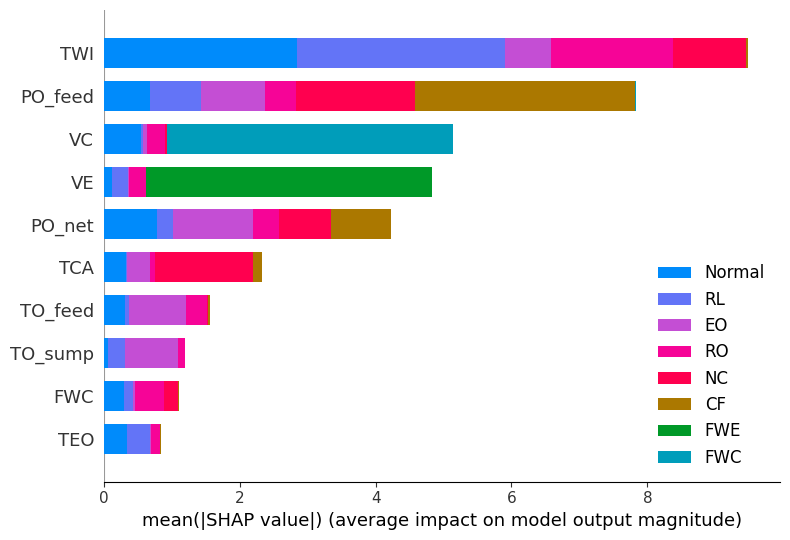

In [10]:
#使用tree explainer
explainer = shap.TreeExplainer(lgbm)
#计算shap值
shap_values = explainer.shap_values(xtrain)
#基线值 就是训练集的目标变量的拟合值的均值
expected_value = explainer.expected_value

shap.summary_plot(shap_values
                  ,xtrain
                  ,class_names= class_names
                  ,max_display = 10
                  #,feature_names=feature_names
                  #,plot_type="bar"
                  )

## XGBoost

In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
ytrain_one = label_encoder.fit(ytrain)
ytrainx = ytrain_one.transform(ytrain)
ytest_one = label_encoder.fit(ytest)
ytestx = ytest_one.transform(ytest)
xgb = XGBClassifier(eval_metric=['mlogloss','auc','error'],random_state=10)
xgb_ = XGBClassifier(eval_metric=['mlogloss','auc','error'],random_state=10)
xgb.fit(xtrain, ytrainx)
time1 = time.time()
xgb_pred = xgb.predict(xtest)
xgb_preds = [round(value) for value in xgb_pred]
xgb_f1 = f1_score(ytestx, xgb_preds,average='weighted')
print("time:",(time.time()-time1))
print("f1_score: %.4f"%  (xgb_f1))
print(classification_report(ytestx, xgb_preds,digits=4))
# xgb_cvs_f1 = cross_val_score(xgb_,xtrain,ytrain,scoring="f1_weighted",cv=5).mean()
# print("f1_cvs_score: %.3f%%" % (xgb_cvs_f1 * 100.0))

time: 0.04538726806640625
f1_score: 0.9996
              precision    recall  f1-score   support

           0     1.0000    0.9994    0.9997      1557
           1     0.9994    0.9987    0.9990      1557
           2     1.0000    1.0000    1.0000      1557
           3     1.0000    0.9994    0.9997      1557
           4     1.0000    1.0000    1.0000      1557
           5     0.9974    1.0000    0.9987      1557
           6     1.0000    0.9994    0.9997      1557
           7     1.0000    1.0000    1.0000      1557

    accuracy                         0.9996     12456
   macro avg     0.9996    0.9996    0.9996     12456
weighted avg     0.9996    0.9996    0.9996     12456



### SHAP analysis of XGBoost

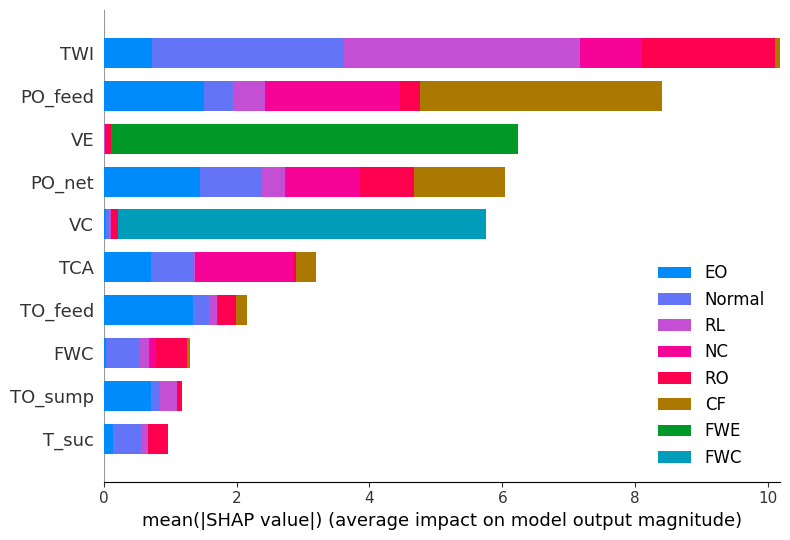

In [12]:
#使用tree explainer
explainer = shap.TreeExplainer(xgb)
#计算shap值
shap_values = explainer.shap_values(xtrain)
#基线值 就是训练集的目标变量的拟合值的均值
expected_value = explainer.expected_value

shap.summary_plot(shap_values
                  ,xtrain
                  ,class_names= class_names
                  ,max_display = 10
                  #,feature_names=feature_names
                  #,plot_type="bar"
                  )

## CatBoost

In [11]:
catb=CatBoostClassifier(loss_function='MultiClass'
                        ,eval_metric= 'MultiClass'
#                          ,learning_rate=0.2
#                          ,depth=10
#                          ,iterations=500
                         ,silent=True
                        )

catb.fit(xtrain, ytrain
         #,cat_features=[14]
        )

time2 = time.time()
pre = catb.predict(xtest)
catb_f1 = f1_score(ytest, pre,average='weighted')
print("time:",(time.time()-time2))
print("f1_score: %.4f"%  (catb_f1))
print(classification_report(ytest,pre,digits=4))
# catb_cvs_f1 = cross_val_score(catb_,xtrain,ytrain,scoring="f1_weighted",cv=5).mean()
# print("f1_cvs_score: %.3f%%" % (catb_cvs_f1 * 100.0))

time: 0.06062436103820801
f1_score: 0.9998
              precision    recall  f1-score   support

          CF     1.0000    1.0000    1.0000      1557
          EO     0.9987    1.0000    0.9994      1557
         FWC     1.0000    1.0000    1.0000      1557
         FWE     1.0000    0.9994    0.9997      1557
          NC     1.0000    1.0000    1.0000      1557
      Normal     0.9994    1.0000    0.9997      1557
          RL     1.0000    0.9994    0.9997      1557
          RO     1.0000    0.9994    0.9997      1557

    accuracy                         0.9998     12456
   macro avg     0.9998    0.9998    0.9998     12456
weighted avg     0.9998    0.9998    0.9998     12456



### SHAP analysis of CatBoost

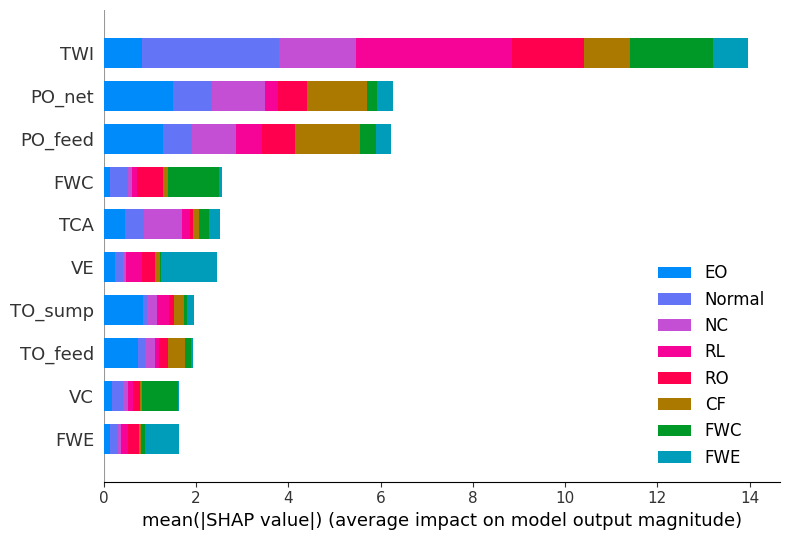

In [15]:
#使用tree explainer
explainer = shap.TreeExplainer(catb)
#计算shap值
shap_values = explainer.shap_values(xtrain)
#基线值 就是训练集的目标变量的拟合值的均值
expected_value = explainer.expected_value

shap.summary_plot(shap_values
                  ,xtrain
                  ,class_names= class_names
                  ,max_display = 10
                  #,feature_names=feature_names
                  #,plot_type="bar"
                  )

## Normalized feature weight calculation (NFWC)

In [10]:
NFWC = pd.read_excel(r"NFWC.xlsx")
NFWC

,EMs:,1,RF,2,XGBoost,3,CatBoost,4,LightGBM,NFW
0,Features,r,w,r,w,r,w,r,w,W
1,TWI,10,2.499,10,2.499,10,2.4995,10,2.4995,9.997
2,PO_feed,8,1.9992,9,2.2491,8,1.9996,9,2.24955,8.49745
3,PO_net,9,2.2491,7,1.7493,9,2.24955,6,1.4997,7.74765
4,VE,7,1.7493,8,1.9992,5,1.24975,7,1.74965,6.7479
5,VC,6,1.4994,6,1.4994,2,0.4999,8,1.9996,5.4983
6,TCA,3,0.7497,5,1.2495,6,1.4997,5,1.24975,4.74865
7,FWC,5,1.2495,3,0.7497,7,1.74965,2,0.4999,4.24875
8,TO_feed,1,0.2499,4,0.9996,3,0.74985,4,0.9998,2.99915
9,TO_sump,0,0,2,0.4998,4,0.9998,3,0.74985,2.24945


## Correlation analysis 

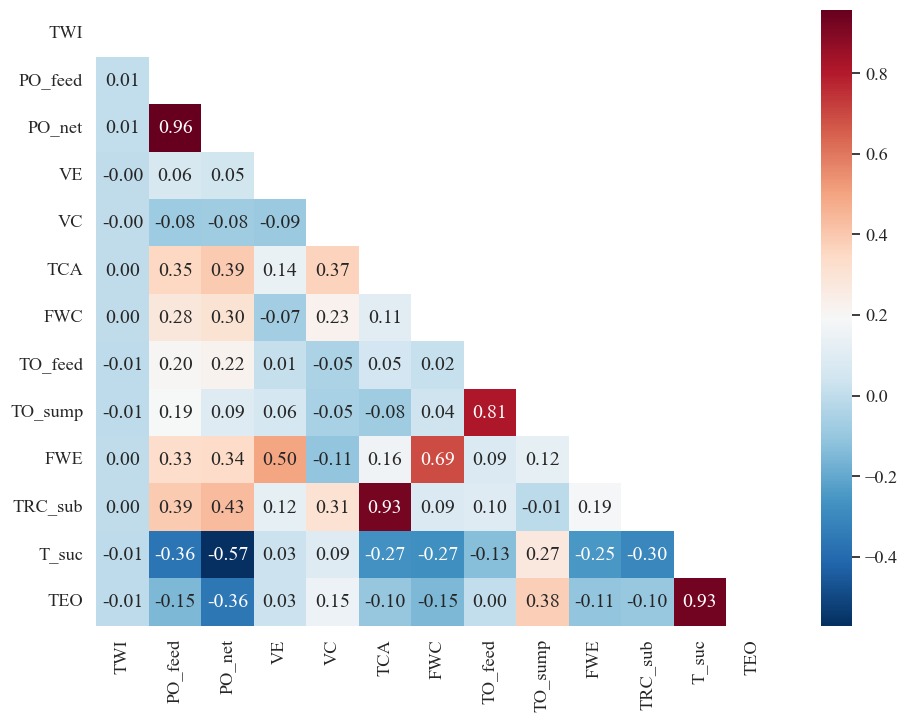

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
xr=data[['TWI','PO_feed','PO_net','VE','VC','TCA','FWC','TO_feed','TO_sump','FWE','TRC_sub','T_suc','TEO']]  
mask = np.zeros_like(xr.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(11, 8))
sns.set_theme(style="whitegrid"
              ,font='Times New Roman'
              ,font_scale=1.2
             )

sns.heatmap(x.corr()
            ,cmap="RdBu_r"
            ,annot=True 
            ,fmt='.2f'
            ,mask=mask
           )
# plt.savefig('correlation.png', dpi=1000, bbox_inches='tight')